In [1]:
import sys
sys.path.insert(0, "../")

In [26]:
import pandas as pd
import numpy as np
import scanpy as sc

In [3]:
import simul.base.utils as utils
import simul.simulate.run as run
import simul.cnv.profiles as cnvprofile
import simul.cnv.sampling as cnvsample
import simul.patients.dataset as patut
from simul.base.config import SimCellConfig

# Create dataset

In [4]:
anchors = ["CD4","CD8A","CD7"]

In [5]:
adatavar = pd.read_csv("/Users/josephineyates/Documents/scProject/notebooks/adatavar.csv",index_col=0)

In [6]:
genome = cnvprofile.Genome(genes_df=adatavar, chromosome_column="chromosome", start_column="start")

In [7]:
genome

In [8]:
CNVGenerator = cnvprofile.CNVPerBatchGenerator(
        genome=genome,
        anchors = anchors,
        chromosomes_gain=["chr1","chr2","chr4","chr5","chr10","chr11","chr14","chr19","chr20"],
        chromosomes_loss=["chr3","chr6","chr8","chr13","chr16","chr18",],
        dropout=0.5,
        dropout_child=0.1,
        p_anchor = 0.2,
        min_region_length=200,
        max_region_length=300,
        seed = np.random.randint(100),
)

In [9]:
dataset = patut.Dataset(
    n_batches=15,
    #n_batches = 6,
    n_programs=3,
    CNVGenerator=CNVGenerator,
    seed=np.random.randint(100),
    n_subclones_min=1,
    n_subclones_max=3,
    n_malignant_max=400,
    n_malignant_min=200,
    n_healthy_max=250,
    n_healthy_min=100,
    subclone_alpha=5,
    
)

Child similar to ancestral, regenerating...


In [10]:
for pat in dataset.patients:
    print(pat.batch, pat.n_total_cells(), pat.subclone_proportions)

patient1 388 [0.67455332 0.32544668]
patient2 519 [0.39323398 0.39959967 0.20716635]
patient3 514 [0.80399135 0.19600865]
patient4 402 [0.40739129 0.59260871]
patient5 511 [0.58136778 0.41863222]
patient6 535 [0.53132671 0.46867329]
patient7 444 [1.]
patient8 410 [0.25941029 0.37809973 0.36248999]
patient9 475 [0.50784823 0.42234774 0.06980403]
patient10 417 [0.36129366 0.63870634]
patient11 329 [1.]
patient12 419 [0.40039974 0.17293356 0.4266667 ]
patient13 609 [0.39229412 0.60770588]
patient14 606 [1.]
patient15 541 [0.43701704 0.47808763 0.08489534]


In [11]:
anchor_alphas = utils.generate_anchor_alphas(anchors=anchors, alpha_add=10, start_alpha=[5,10,10])

In [12]:
anchor_alphas

{(False, False, False): [5, 10, 10],
 (False, False, True): [5, 10, 20],
 (False, True, False): [5, 20, 10],
 (False, True, True): [5, 20, 20],
 (True, False, False): [15, 10, 10],
 (True, False, True): [15, 10, 20],
 (True, True, False): [15, 20, 10],
 (True, True, True): [15, 20, 20]}

In [13]:
MIN_PROGRAMS = 2
DROPOUT = 0

In [14]:
distribution = cnvsample.generate_probabilities(
    anchors_to_alphas=anchor_alphas,
    batches=dataset.batches,
    min_programs=MIN_PROGRAMS,
    prob_dropout=DROPOUT,
    program_names=dataset.programs,
    seed=np.random.randint(100),
)

In [15]:
distribution._conditional_probability

{((False, False, False),
  'patient1'): array([0.2157064 , 0.39503673, 0.38925687]),
 ((False, False, True),
  'patient1'): array([0.08196954, 0.33852896, 0.5795015 ]),
 ((False, True, False),
  'patient1'): array([0.12491404, 0.62629468, 0.24879128]),
 ((False, True, True),
  'patient1'): array([0.12947777, 0.525479  , 0.34504323]),
 ((True, False, False),
  'patient1'): array([0.41895201, 0.21382356, 0.36722443]),
 ((True, False, True),
  'patient1'): array([0.40713142, 0.16989604, 0.42297254]),
 ((True, True, False),
  'patient1'): array([0.34850126, 0.41179081, 0.23970793]),
 ((True, True, True), 'patient1'): array([0.27895346, 0.28657865, 0.43446789]),
 ((False, False, False),
  'patient2'): array([0.23983373, 0.34586993, 0.41429634]),
 ((False, False, True),
  'patient2'): array([0.09761157, 0.25338274, 0.64900569]),
 ((False, True, False),
  'patient2'): array([0.10506559, 0.53954255, 0.35539186]),
 ((False, True, True),
  'patient2'): array([0.18961498, 0.41275304, 0.39763198])

In [16]:
celltypes = ["Macro","Plasma","program1","program2","program3"]

In [17]:
full_obs = run.simulate_full_obs(dataset=dataset, prob_dist=distribution, p_drop = [0.3, 0.2])

In [127]:
rng = np.random.default_rng(12345)

n_cells = np.sum([full_obs[pat].shape[0] for pat in full_obs])

config = SimCellConfig(n_genes=adatavar.shape[0], 
                        n_cells=n_cells, group_names=celltypes, 
                       p_de_list=np.array([0.3,0.3,0.4,0.4,0.4]), 
                      p_down_list=np.array([0.5,0.5,0.3,0.3,0.3]), 
                      de_location_list=np.array([2,2,0.8,0.8,0.8]),
                      de_scale_list=np.array([1,1,0.5,0.5,0.5]))


In [128]:
mean_pc = run.get_common_mean_pc(config=config, rng=rng)

Sampling original mean...
Sampling outlier factors...
Changing mean to fit outliers...
Scaling by library size...
Calculating cell specific mean...


In [129]:
transformed_means = run.get_group_cnv_transformed(mean_pc=mean_pc, 
                                          full_obs=full_obs, 
                                          config=config, dataset=dataset, rng=rng)

Getting group specific DE factors...
Transform means linked to groups...
Transform means linked to CNV profile...


In [130]:
final_counts_pp = {}
for pat in transformed_means:
    final_counts_pp[pat] = run.sample_counts_patient(mean_pc=transformed_means[pat], 
                                                 config=config, rng=rng)

Getting BCV...
Calculating trended mean...
Sampling true counts...
Computing gene and cell-specific dropout probability...
Sampling dropout...
Transforming counts with dropout...
Getting BCV...
Calculating trended mean...
Sampling true counts...
Computing gene and cell-specific dropout probability...
Sampling dropout...
Transforming counts with dropout...
Getting BCV...
Calculating trended mean...
Sampling true counts...
Computing gene and cell-specific dropout probability...
Sampling dropout...
Transforming counts with dropout...
Getting BCV...
Calculating trended mean...
Sampling true counts...
Computing gene and cell-specific dropout probability...
Sampling dropout...
Transforming counts with dropout...
Getting BCV...
Calculating trended mean...
Sampling true counts...
Computing gene and cell-specific dropout probability...
Sampling dropout...
Transforming counts with dropout...
Getting BCV...
Calculating trended mean...
Sampling true counts...
Computing gene and cell-specific dropo

In [131]:
adatas = run.counts_to_adata(counts_pp=final_counts_pp, observations=full_obs)

In [138]:
simadata = adatas[0].concatenate(*adatas[1:])

In [139]:
sc.pp.calculate_qc_metrics(simadata, percent_top=None, log1p=True, inplace=True)

sc.pp.normalize_total(simadata, target_sum=10000)
sc.pp.log1p(simadata)

In [140]:
maladata = simadata[simadata.obs.malignant_key=="malignant"].copy()
sc.pp.highly_variable_genes(maladata, n_top_genes=2000)
simadata = simadata[:,maladata.var.highly_variable].copy()

In [141]:
sc.tl.pca(simadata)

In [142]:
simadata.obs["pat_subclone"] = simadata.obs.subclone.astype(str) + "_" + simadata.obs.batch.astype(str)
simadata.obs["pat_subclone"] = simadata.obs["pat_subclone"].apply(lambda x: "NA" if "NA" in x else x)

/Users/josephineyates/opt/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'subclone' as categorical
/Users/josephineyates/opt/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'program' as categorical
/Users/josephineyates/opt/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be remove

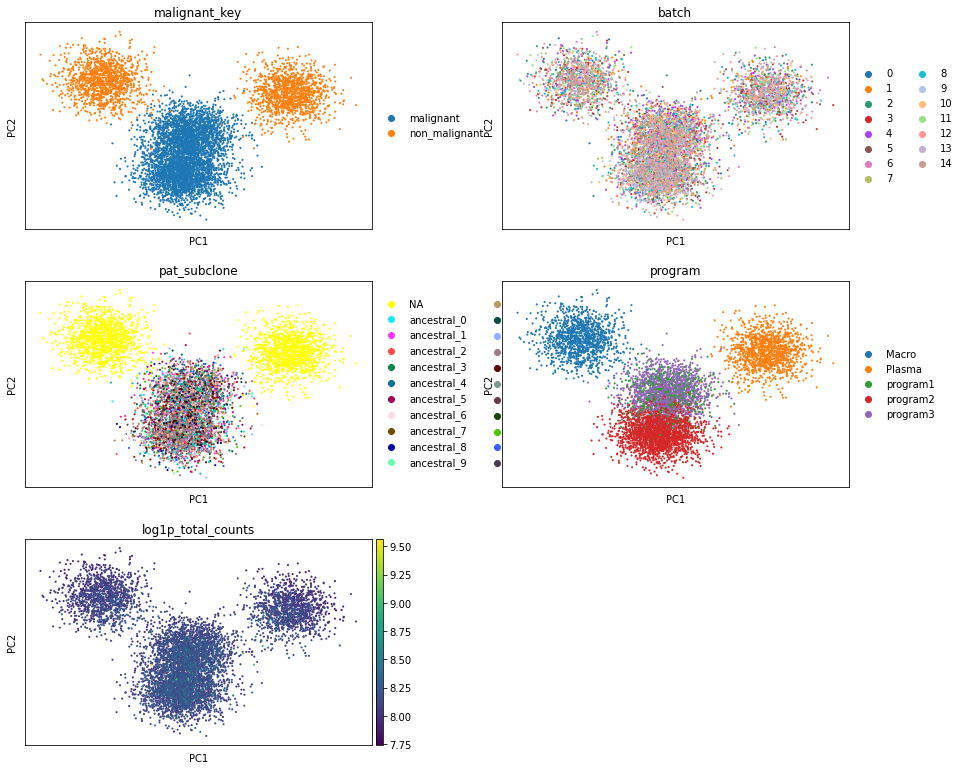

In [143]:
sc.pl.pca(simadata,color=["malignant_key","batch","pat_subclone",
 "program","log1p_total_counts",] ,ncols=2, wspace=0.25,)
                 #save="highcnv_subclones.png")

/Users/josephineyates/opt/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'subclone' as categorical
/Users/josephineyates/opt/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'program' as categorical
/Users/josephineyates/opt/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be remove

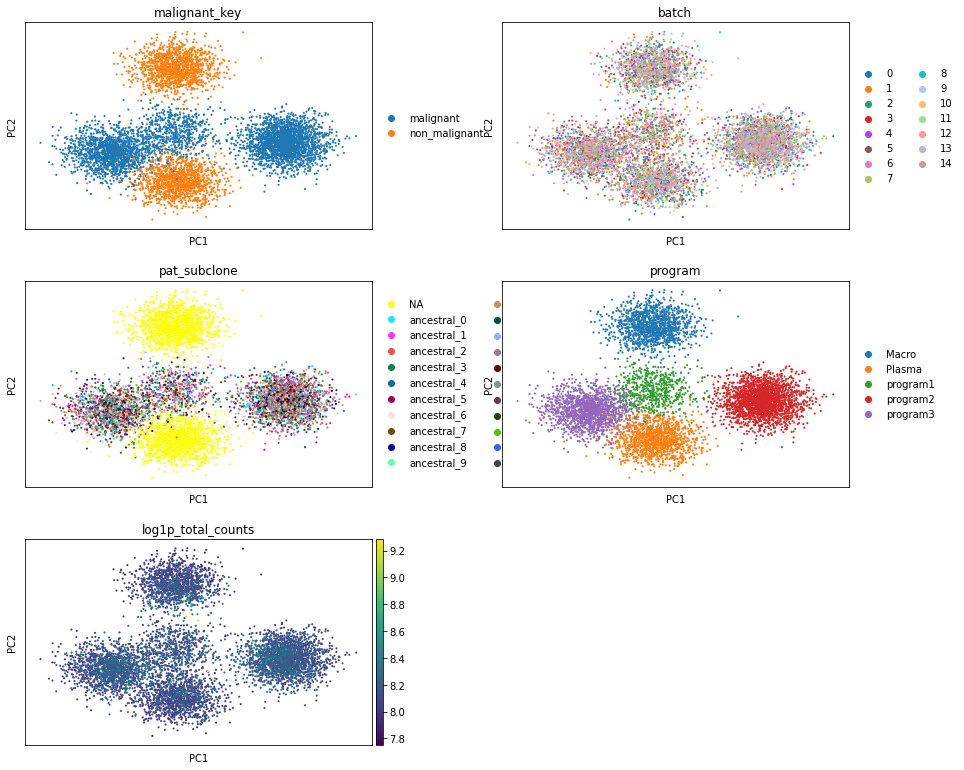

In [48]:
sc.pl.pca(simadata,color=["malignant_key","batch","pat_subclone",
 "program","log1p_total_counts",] ,ncols=2, wspace=0.25,)
                 #save="highcnv_subclones.png")

/Users/josephineyates/opt/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'subclone' as categorical
/Users/josephineyates/opt/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'program' as categorical
/Users/josephineyates/opt/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be remove

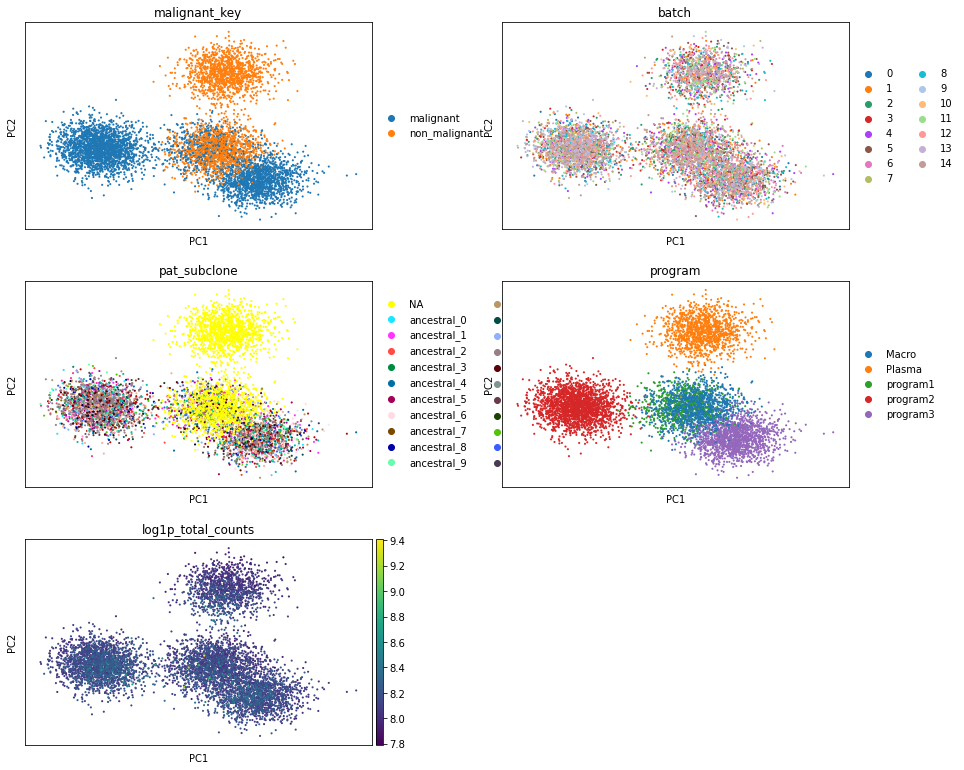

In [86]:
sc.pl.pca(simadata,color=["malignant_key","batch","pat_subclone",
 "program","log1p_total_counts",] ,ncols=2, wspace=0.25,)
                 #save="highcnv_subclones.png")

In [210]:
from scipy.interpolate import interp1d
def brownian_bridge(N: int = 5, x: int = 0, y: int = 0, n: int = 100, sigma_fac: float = 0.8) -> callable:
    dt = 1 / (N - 1)
    t = np.linspace(0, 1, num=N)
    sigma2 = np.random.uniform(low=0, high=sigma_fac*np.mean([x,y]))
    X = np.append([0], np.cumsum(np.random.normal(loc=0, scale=sigma2, size=N-1))*np.sqrt(dt))
    BB = x + X - t * (X[N-1] - y + x)
    BB = interp1d(t, BB, kind="cubic")
    return BB

In [221]:
BB = brownian_bridge(x=0, y=1, sigma_fac=4)

<AxesSubplot:>

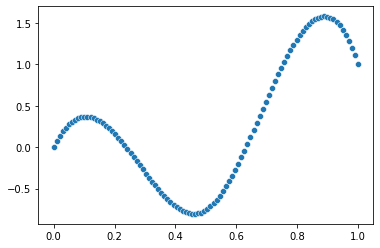

In [222]:
import seaborn as sns
sns.scatterplot(x=np.linspace(0,1,num=100),y=BB(np.linspace(0,1,num=100)))

In [ ]:
path_from = [0, 1, 1, 2]

In [ ]:
def get_path_de(config: SimCellConfig,
                path_from: Union[List[int],np.ndarray]) -> Dict[str, np.ndarray]:
    
    for path in path_from:
                de.facs <- getLNormFactors(nGenes, de.prob[path], de.downProb[path],
                                   de.facLoc[path], de.facScale[path])

In [ ]:
splatSimPathDE <- function(sim, params) {

    nGenes <- getParam(params, "nGenes")
    de.prob <- getParam(params, "de.prob")
    de.downProb <- getParam(params, "de.downProb")
    de.facLoc <- getParam(params, "de.facLoc")
    de.facScale <- getParam(params, "de.facScale")
    path.from <- getParam(params, "path.from")

    path.order <- getPathOrder(path.from)
    for (path in path.order) {
        from <- path.from[path]
        if (from == 0) {
            means.gene <- rowData(sim)$GeneMean
        } else {
            means.gene <- rowData(sim)[[paste0("GeneMeanPath", from)]]
        }
        de.facs <- getLNormFactors(nGenes, de.prob[path], de.downProb[path],
                                   de.facLoc[path], de.facScale[path])
        path.means.gene <- means.gene * de.facs
        rowData(sim)[[paste0("DEFacPath", path)]] <- de.facs
    }

    return(sim)
}
